# Assignment 3

## Angelo Rosace

**ATP Production**

We got a set of results form a research concerning ATP production. The researchers conducting this study inferred a model explaining the process from the data collected.

The model is defined as follows:

**ATP = a * Proteins + b * Carbohydrates + c * Fats + ε**

We know that each value of Protein, Carbohydrates and Fats value is relative to a maximum established by the researchers. They are chosen in a random fashion to give as a diet to the patients.
The distributions for them are:

- Proteins ~ Uniform(0,1)
- Carbohydrates ~ Uniform(0,1)
- Fats ~ Uniform(0,1)

**1. Write a python script that construct the model that we were investigating in pyMC3.**

In [1]:
import pymc3 as pm
import pandas as pd
import seaborn as sn

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


First of all let's read our data and inspect them.

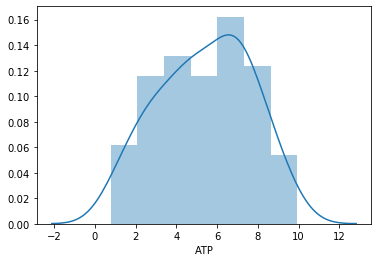

In [2]:
diet_and_atp = pd.read_csv("diet_and_atp.tsv", sep = "\t", header = [0])
atp = diet_and_atp["ATP"]
prot_from_file = diet_and_atp["Protein"]
carb_from_file = diet_and_atp["Carbohydrates"]
fat_from_file = diet_and_atp["Fat"]
sn.distplot(atp, label="ATP")

The plot above represent the distribuion of the ATP as described by our data set. As we can see the distribution seems to follow a normal distribution. This means that in order to construct a model for this biological process we will take in consideration two main variables: the mean and the standard deviation.

In order to make some educated guesses for describing the model I will analyze my data.
First of all I am interested in seing how much the atp value fluctuates in order to have an idea about the standard deviation of the model.

In [3]:
print("The maximum value for the atp is: ", max(atp), "\nThe minimum value for the atp is: ", min(atp))

The maximum value for the atp is:  9.93 
The minimum value for the atp is:  0.78


Considering the data above I will consider the standard deviation to be around 5.

We now miss the mean of the distribution. For the purpose of this assignment we consider it to be a deterministic variable described by the function that makes up the model.
The function it self is influenced by three unknown coeficients: a, b and c.
Theese three coeficients are respectively associated with the three variables that explain the model: protien, carbohidrate, fat.

The researchers already provided us with information about the distributions of the three variables associated with the coeficients and we will use them as our prior beliefs. They all follow a uniform distribution between 0 and 1.

Taking in account this pieces of information we can finally construct the model as follows:

In [8]:
with pm.Model() as model:
    #1- Prior distributions of the three unknown coefficients
    a = pm.Normal("a", mu=1, sd=2)
    b = pm.Normal("b", mu=1, sd=2)
    c = pm.Normal("c", mu=1, sd=2)
    
    #2 - Prior distributions of the values of the the variables
    prot = pm.Uniform("prot", 0, 1)
    carb = pm.Uniform("carb", 0, 1)
    fat = pm.Uniform("fat", 0, 1)
    
    #3 - Distributions of the product between coefficients and values of the variable
    P = pm.Normal("P", mu=a * prot, sd=5, observed=prot_from_file)
    C = pm.Normal("C", mu=b * carb, sd=5, observed=carb_from_file)
    F = pm.Normal("F", mu=c * fat, sd=5, observed=fat_from_file)
    
    #Distribution of the function describing the model
    obs = pm.Normal("obs", mu=P+C+F, sd=5, observed=atp)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [fat]
>Metropolis: [carb]
>Metropolis: [prot]
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [12:07<00:00, 552.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


As we can see from the implementation of the model, we have three main blocks: one modeling the coefficients of the three variables (**1**) , one describing the variables (**2**) and one describing the interaction between the two (**3**). 

In the first block we model the coefficients. We decided to assume that they follow a normal distribution. This has been decided in order to be as general and unbiased as possible and not give out too much information in our prior beliefs.

Then, the block for the variables, accordingly to the assignment's statement, models the three variables as uniform distributions.

Finally, the last model uses both coeficient and variables to model the outcomes for the proteins, the carbohidrates and the fat.

Once our prior for the model have been defined we just modeled the function describing the atp generation process by means of our previously defined priors.

By applying this model to the data obtained from the experiment we can then find out the values of the coefficents.
This is done by using the metropolis algorithm. We decided to perform 10^5 iterations and before plotting the results the first 
20000 results have been discarded. This is becuase they would be too sparse and would worse represent the true values of the coefficients.

The result of the metropolis algorithm is a trace of results for the unknown variables to be inferred.
Theese have then been plotted below.

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/srv/conda/envs/notebook/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in

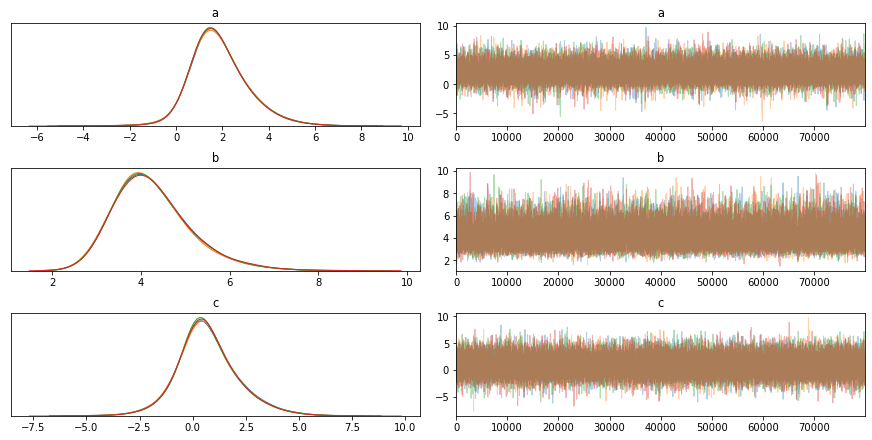

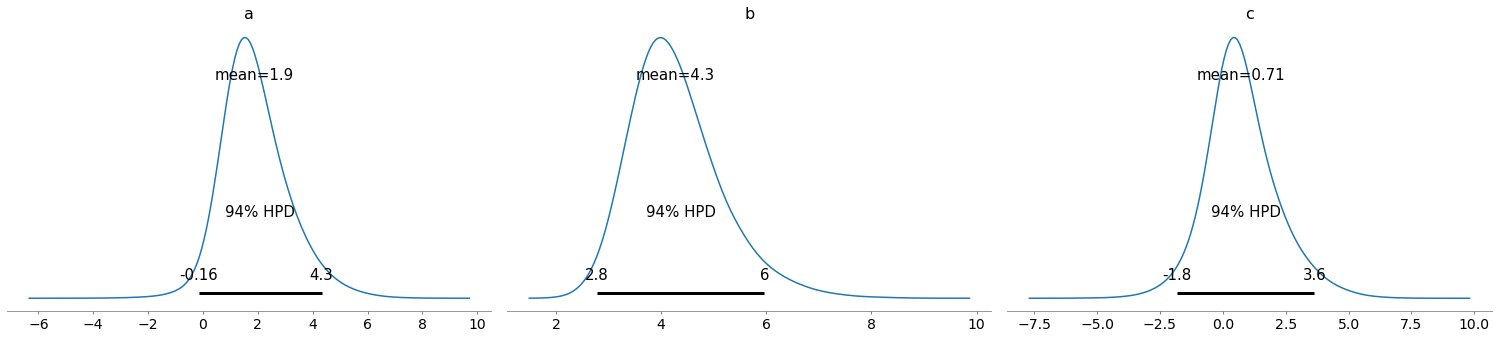

In [9]:
pm.plots.traceplot(burned_trace, varnames=["a", "b","c"])
pm.plot_posterior(burned_trace, varnames=["a", "b","c"]);

The first three pairs of plots represent the trace plots of the three coefficients. Although in all of them we see a lot of fluctuation we can clearly see how all of them are converging. The plots don't allow us to tell which is the actual value of the coefficient but it gives us a range of possible values. Therefore, we need to inspect the posterior distribution to have a clear idea of the values of the coefficients. 

Not reaching a clear enough result could be due to many factors, they being for expample a wrong choice of the prior distributions (which could be not as representative of the model as other ones or biased) or simply a too low number of iterations.

For example if we decide to perform 10^3 iterations we will se that the posterior distributions experience a bigger amount of fluctuation and do not give raise to a smooth posterior distribution. On the other hand, if we decide to higher the number of iterations we will end up with much clearer results.

One thing to take into account is that the model itself is not that complicated. This is the reason why, although we can sense that the prediction could be refined, a number of 10^3 iterations generates results that are actually not as far from the reality as compared to the results generated after 10^5 iterations.

This being said, by looking at the last three distributions (the posterior distributions) we see the mean of each of them, that is the best predicted value of the coefficients.

We then have that: 
- the value for coefficent for the protein variable is: **1.9**
- the value for coefficent for the carbohidrate variable is: **4.3**
- the value for coefficent for the fat variable is: **0.71**

As a last remark is important to say that by further tweaking the parameters we could end up obtaining better or worst predictions. For example, by increasing or lowering the standard deviation for the distributions of the product between the coefficients and the variables, we can see how the posterior distributions skew in turn to the right or to the left and therefore returning other values as their means.